In [7]:
from google.colab import files
uploaded = files.upload()

Saving weatherstats_toronto_daily_clean.csv to weatherstats_toronto_daily_clean (1).csv


In [8]:
# =============================================================================
# Part 1 - Data Preprocessing
# =============================================================================

# Import necesary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow import keras

# Import the Dataset

df = pd.read_csv("weatherstats_toronto_daily_clean.csv")

# Split new data into Train and Test

df_train = df.iloc[:8000, 2:3].values
df_test = df.iloc[8000:, 2:3].values

# Feature scaling

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_train)
df_train_scaled = scaler.transform(df_train)

# Create a data structure with 30 timesteps and 1 output

X_train = []
y_train = []
for i in range(30, len(df_train)):
    X_train.append(df_train_scaled[i-30:i, 0])
    y_train.append(df_train_scaled[i, 0])
    
# Convert to np array before using for RNN

X_train = np.array(X_train)
y_train = np.array(y_train)

# Reshaping - adding a new dimension

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)

X_train shape:  (7970, 30, 1)
y_train shape:  (7970,)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 30)            3840      
                                                                 
 lstm_1 (LSTM)               (None, 30, 30)            7320      
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 18,511
Trainable params: 18,511
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
638/638 [========================

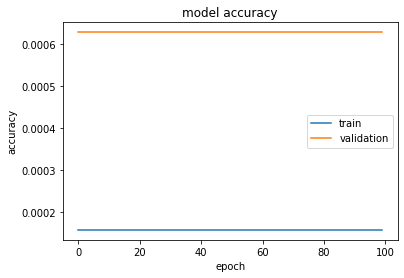

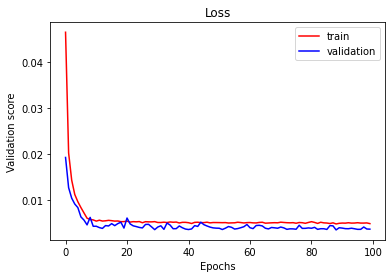

In [9]:
# =============================================================================
# Part 2 - Building the RNN
# =============================================================================
# Set up the model
def lstm():
    model = Sequential()
    
    model.add(LSTM(30, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(30, return_sequences=True))
    model.add(LSTM(30))
    model.add(Dropout(0.6))
    model.add(Dense(1))
    
    return model

# Compile the model
RNN = lstm()

RNN.compile(optimizer='adam', loss='mean_squared_error', 
                     metrics=['accuracy'])
print(RNN.summary())

# Fit the model

history = RNN.fit(X_train, y_train, batch_size=10, epochs=100,
                            validation_split=0.2,
              shuffle=False)

# Plot the outcome loss VS val_loss


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

plt.subplots() # open a new plot
plt.plot(history.history['loss'], 'r', label='train')
plt.plot(history.history['val_loss'], 'b', label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.legend()
plt.show()

# save the final model

#RNN.save('average_temperature.h5')

# to load keras model
# my_regressor = keras.models.load_model('average_temperature.h5')

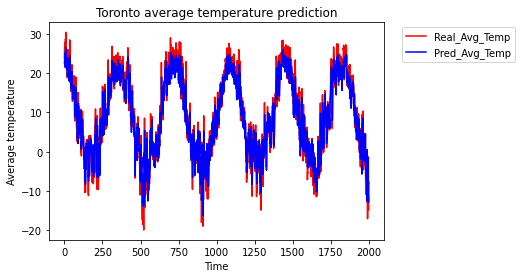

In [12]:
# =============================================================================
# Part 3 - Making the predictions and visualising the results
# =============================================================================

# Feature scaling
# Concatenate X_train and X_test
df_total = df.iloc[:, 2:3]
inputs = df_total[len(df_total) - len(df.iloc[8000:, 2:3]) - 30:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

# Create a data structure with 30 timesteps
X_test = []
for i in range(30, 30+len(df.iloc[8000:, 2:3])):
    X_test.append(inputs[i-30:i, 0])

# Convert to np array before using for RNN
X_test = np.array(X_test)

# Reshaping - adding a new dimension
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
# Identify the predicted values
predicted_avg_temperature = RNN.predict(X_test)

# Inverse the scaling to put them back to the normal values
predicted_avg_temperature = scaler.inverse_transform(predicted_avg_temperature)    
    
# Visualising the results
plt.subplots()
plt.plot(df_test, color = 'red', label = 'Real_Avg_Temp')
plt.plot(predicted_avg_temperature, color = 'blue', label = 'Pred_Avg_Temp')
plt.title('Toronto average temperature prediction')
plt.xlabel('Time')
plt.ylabel('Average temperature')
plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.show()  

In [13]:
# =============================================================================
# Part 4 - Tuning the Recurrent Neural Network (LSTM)
# =============================================================================

# Tuning the RNN
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
def build_regressor(optimizer):
  regressor = Sequential()
  regressor.add(LSTM(30, return_sequences=True, input_shape=(X_train.shape[1], 1)))
  regressor.add(LSTM(30, return_sequences=True))
  regressor.add(LSTM(30))
  regressor.add(Dropout(0.6))
  regressor.add(Dense(1))
  regressor.compile(optimizer=optimizer, loss='mean_squared_error')
  return regressor

regressor = KerasRegressor(build_fn=build_regressor)

parameters = {
    'epochs' : [50, 100, 150],
    'optimizer' : ['adam', 'rmsprop']
}
grid_search = GridSearchCV(estimator = regressor, param_grid = parameters,
                           scoring = 'neg_mean_squared_error', cv = 3)
grid_search = grid_search.fit(X_train, y_train)

best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  app.launch_new_instance()


Epoch 1/50
167/167 [==============================] - 5s 7ms/step - loss: 0.0411
Epoch 2/50
167/167 [==============================] - 1s 7ms/step - loss: 0.0237
Epoch 3/50
167/167 [==============================] - 1s 7ms/step - loss: 0.0207
Epoch 4/50
167/167 [==============================] - 1s 7ms/step - loss: 0.0180
Epoch 5/50
167/167 [==============================] - 1s 7ms/step - loss: 0.0157
Epoch 6/50
167/167 [==============================] - 1s 7ms/step - loss: 0.0141
Epoch 7/50
167/167 [==============================] - 1s 7ms/step - loss: 0.0126
Epoch 8/50
167/167 [==============================] - 1s 7ms/step - loss: 0.0114
Epoch 9/50
167/167 [==============================] - 1s 7ms/step - loss: 0.0107
Epoch 10/50
167/167 [==============================] - 1s 7ms/step - loss: 0.0100
Epoch 11/50
167/167 [==============================] - 1s 7ms/step - loss: 0.0098
Epoch 12/50
167/167 [==============================] - 1s 8ms/step - loss: 0.0092
Epoch 13/50
167/167 [====

In [23]:
print('best parameters:\n', best_parameters)
print('best accuracy:\n', best_accuracy)

best parameters:
 {'epochs': 100, 'optimizer': 'adam'}
best accuracy:
 -0.0034007596930891028
